<a href="https://colab.research.google.com/github/pachterlab/CBP_2022/blob/main/notebooks/combinedFigurePlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Sun Sep 26 20:04:34 UTC 2021


In [ ]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 575 (delta 351), reused 86 (delta 25), pack-reused 0
Receiving objects: 100% (575/575), 83.21 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (351/351), done.


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn
!pip3 install --quiet scvi-tools

     |████████████████████████████████| 127 kB 13.2 MB/s 
     |████████████████████████████████| 7.7 MB 15.7 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.1 MB/s 
     |████████████████████████████████| 217 kB 14.4 MB/s 
     |████████████████████████████████| 813 kB 45.3 MB/s 
     |████████████████████████████████| 678 kB 45.3 MB/s 
     |████████████████████████████████| 242 kB 54.4 MB/s 
     |████████████████████████████████| 211 kB 55.6 MB/s 
     |████████████████████████████████| 636 kB 65.7 MB/s 
     |████████████████████████████████| 123 kB 65.2 MB/s 
     |████████████████████████████████| 829 kB 51.7 MB/s 
     |████████████████████████████████| 282 kB 53.7 MB/s 
     |████████████████████████████████| 1.3 MB 40.1 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 294 kB 57.0 MB/s 
     |████████████████████████████████| 142 kB 47.3 MB/s 


In [ ]:
%cd /content/CBP_2021/data
!gunzip *.gz

/content/CBP_2021/data


In [ ]:
%cd /content/CBP_2021/scripts

/content/CBP_2021/scripts


## **Install Packages**

In [ ]:
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition
import visualizations as vis

import random
import scvi
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../data'

pcs = 50
n_latent = 50

### **Prediction Accuracy Plots for Cell Type Label Prediction Fig. 2**

In [ ]:
smartPreds = pd.read_csv(data_path+'/allSmartSeqPreds.csv')
netAEpreds = pd.read_csv(data_path+'/netAESmartSeqPreds.csv')
tenxpreds = pd.read_csv(data_path+'/all10XPreds.csv')
matlaspreds = pd.read_csv(data_path+'/allLaMannoPreds0712.csv')

tenxpreds.head()

,Unnamed: 0,Accuracy,Embed,Label
0,0,0.793250,LDVAE,CellType1
1,1,0.791246,LDVAE,CellType1
2,2,0.789642,LDVAE,CellType1
3,3,0.791085,SCANVI,CellType1
4,4,0.792689,SCANVI,CellType1


In [ ]:
netAEpreds.head()

,Unnamed: 0,Accuracy,Embed,Label
0,0,0.775966,netAE,CellType1
1,1,0.918455,netAE,Gender2


Get statistics on differences between methods

In [ ]:
# % Avg Increase in accuracy by Cell Type MCML (NCA-Recon MCML)
avgMCML = np.mean(smartPreds['Accuracy'][smartPreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(smartPreds['Accuracy'][smartPreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg

percs['netAE'] = (avgMCML - netAEpreds.Accuracy[0])/netAEpreds.Accuracy[0]
print(percs)

#tenx data
avgMCML = np.mean(tenxpreds['Accuracy'][tenxpreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(tenxpreds['Accuracy'][tenxpreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg


print(percs)


#developing brain data
avgMCML = np.mean(matlaspreds['Accuracy'][matlaspreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(matlaspreds['Accuracy'][matlaspreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg

print(percs)


{'LDVAE': 0.017879738169281227, 'SCANVI': 0.012199792041766471, 'Recon MCML': -0.0067106887708360775, 'PCA 50D': -0.004787262526550609, 'PCA UMAP Sup.': 0.004124606546532774, 'PCA UMAP': 0.03932142495711097, 'PCA t-SNE': 0.05172805848961584, 'netAE': 0.1468897785951327}
{'LDVAE': 0.03598443909947382, 'SCANVI': 0.02458294184504268, 'Recon MCML': -0.003827071411435752, 'PCA 50D': 0.009041741248825322, 'PCA UMAP Sup.': 0.13713619169864344, 'PCA UMAP': 0.28703080274422904, 'PCA t-SNE': 0.1521759686985722}
{'LDVAE': -0.05019154098335372, 'SCANVI': -0.02420760317118347, 'Recon MCML': 0.10375802711776827, 'PCA 50D': 0.10116509863460293, 'PCA UMAP Sup.': 0.37706361244204717, 'PCA UMAP': 0.4372864210224966, 'PCA t-SNE': 0.28107516233698043}


In [ ]:
#max accuracies
print(max(smartPreds['Accuracy']))
print(max(tenxpreds['Accuracy']))
print(max(matlaspreds['Accuracy']))

0.9160173159999999
0.922885772
0.5892152620000001


In [ ]:
allPreds = pd.concat([smartPreds, netAEpreds,tenxpreds,matlaspreds])

In [ ]:
dataset = ['SmartSeq Mouse VMH Neurons']*(len(smartPreds)+len(netAEpreds)) + ['10X Mouse VMH Neurons']*len(tenxpreds) + ['10X Developing Mouse Brain']*len(matlaspreds)
allPreds['Dataset'] = dataset

In [ ]:
allPreds.head()

,Unnamed: 0,Accuracy,Embed,Label,Dataset
0,0,0.844156,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
1,1,0.867532,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
2,2,0.862338,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
3,3,0.869264,SCANVI,CellType1,SmartSeq Mouse VMH Neurons
4,4,0.867532,SCANVI,CellType1,SmartSeq Mouse VMH Neurons


In [ ]:
subAllPreds = allPreds[allPreds.Label == 'CellType1']
subAllPreds = subAllPreds[~(subAllPreds.Embed == 'NCA 100% MCML')]

In [ ]:
axisFontSize = 9
tickFontSize = 7
errwidth=1
figsize =(7,3)
dodge=0.4

In [ ]:
subAllPreds['Embed'] = [i.replace('NCA-Recon MCML','Cell Type MCML 50D') for i in subAllPreds['Embed']] 

In [ ]:
subAllPreds['Embed'] = [i.replace('Recon MCML','Recon MCML 50D') for i in subAllPreds['Embed']] 

In [ ]:
subAllPreds['Dataset'] = [i.replace('SmartSeq Mouse VMH Neurons','SMART-seq Mouse VMH Neurons\n(3,850 cells)') for i in subAllPreds['Dataset']] 
subAllPreds['Dataset'] = [i.replace('10X Mouse VMH Neurons','10x Mouse VMH Neurons\n(41,580 cells)') for i in subAllPreds['Dataset']] 
subAllPreds['Dataset'] = [i.replace('10X Developing Mouse Brain','10x Developing Mouse Brain\n(292,495 cells)') for i in subAllPreds['Dataset']] 

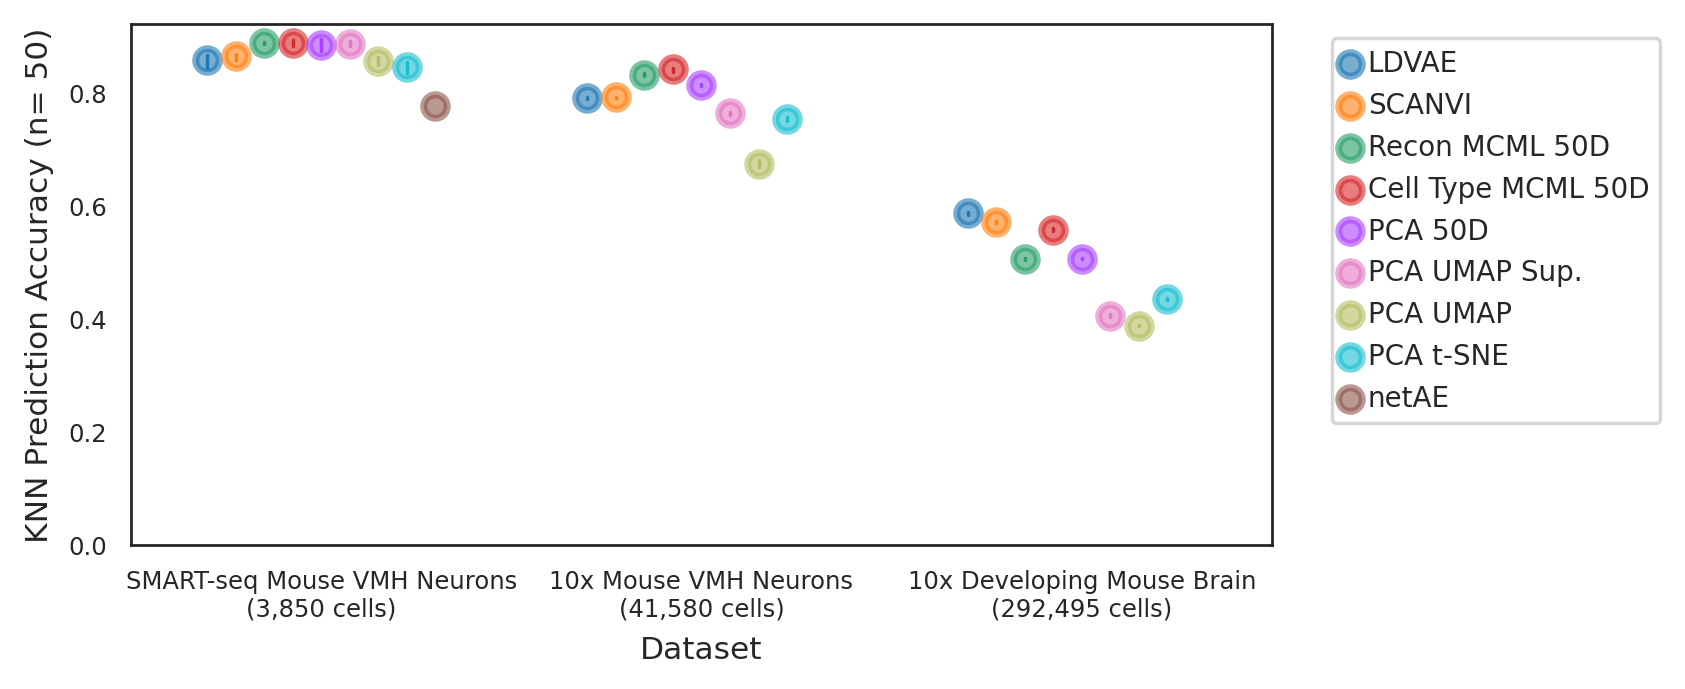

In [ ]:
#Maybe add number of cells below
palette={"LDVAE":sns.color_palette()[0],"SCANVI":sns.color_palette()[1],
                  "Recon MCML 50D":sns.color_palette()[2],"Cell Type MCML 50D":sns.color_palette()[3],"PCA 50D":sns.color_palette()[4],"netAE":sns.color_palette()[5],
                  "PCA UMAP Sup.":sns.color_palette()[6],"PCA UMAP":sns.color_palette()[7],
                  "PCA t-SNE":sns.color_palette()[8]}

plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Accuracy', data=subAllPreds, hue='Embed',palette= palette, err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=0.6)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n= 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

In [ ]:
subAllPreds2 = subAllPreds[~subAllPreds['Embed'].isin(['PCA UMAP Sup.','PCA UMAP','PCA t-SNE'])]

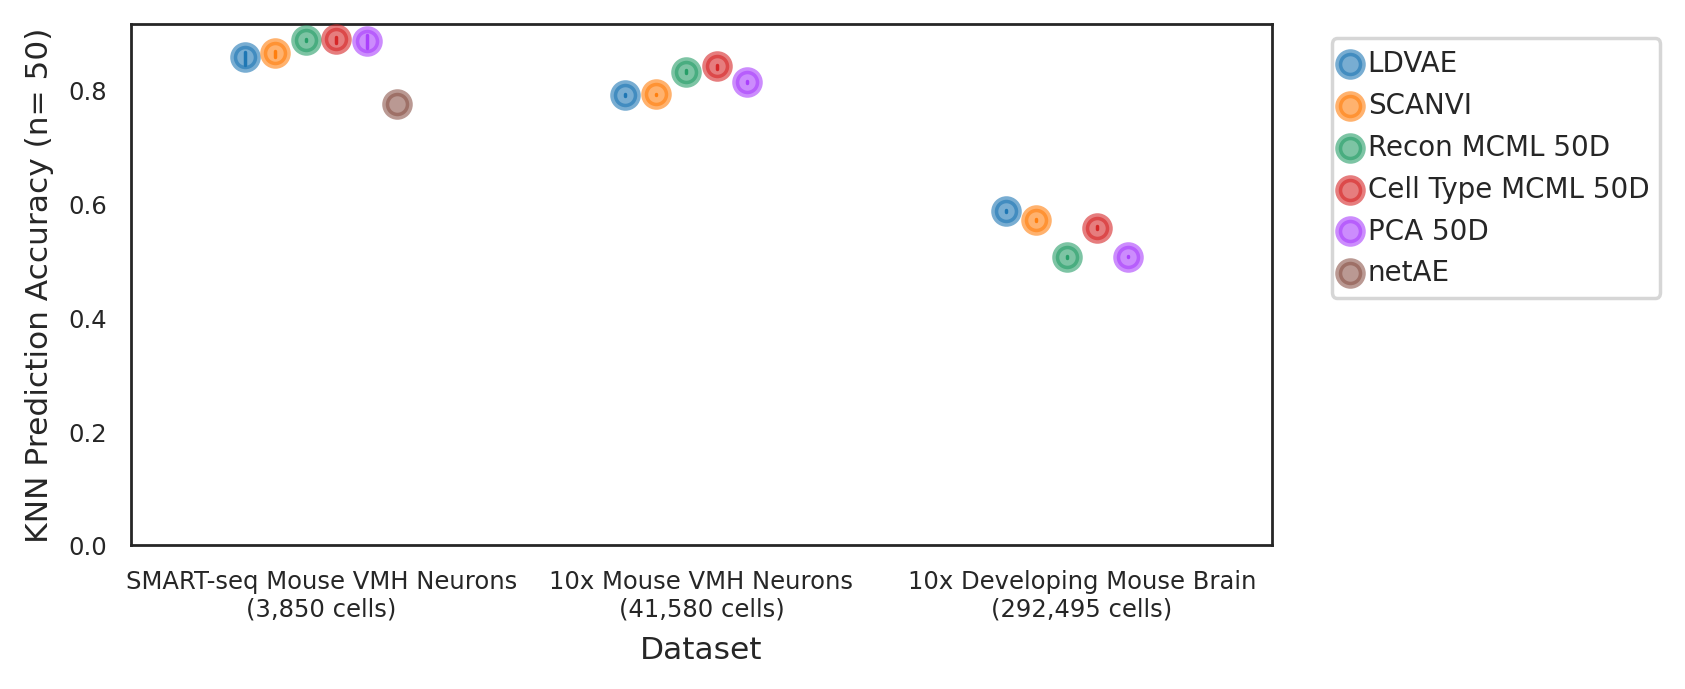

In [ ]:
#Maybe add number of cells below
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Accuracy', data=subAllPreds2, hue='Embed', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n= 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

### **Prediction Accuracy of NCA-MCML with Reduced Fraction of Labeled Data**

In [ ]:
smartPreds = pd.read_csv(data_path+'/lowPercsSmartSeqPreds.csv')
tenxpreds = pd.read_csv(data_path+'/lowPercs10XPreds.csv')
matlaspreds = pd.read_csv(data_path+'/lowPercsLaMannoPreds0715.csv')

tenxpreds.head()

,Unnamed: 0,Accuracy,Percent
0,0,0.844489,0.7
1,1,0.836941,0.6
2,2,0.832660,0.5
3,3,0.822551,0.4
4,4,0.812444,0.3


In [ ]:
allPreds = pd.concat([smartPreds, tenxpreds,matlaspreds])

In [ ]:
dataset = ['SmartSeq Mouse VMH Neurons']*(len(smartPreds)) + ['10X Mouse VMH Neurons']*len(tenxpreds) + ['10X Developing Mouse Brain']*len(matlaspreds)
allPreds['Dataset'] = dataset

In [ ]:
allPreds.head()

,Unnamed: 0,Accuracy,Percent,Dataset
0,0,0.893506,0.7,SmartSeq Mouse VMH Neurons
1,1,0.880519,0.6,SmartSeq Mouse VMH Neurons
2,2,0.876883,0.5,SmartSeq Mouse VMH Neurons
3,3,0.852814,0.4,SmartSeq Mouse VMH Neurons
4,4,0.827829,0.3,SmartSeq Mouse VMH Neurons


In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
allPreds['Dataset'] = [i.replace('SmartSeq Mouse VMH Neurons','SMART-seq Mouse VMH Neurons') for i in allPreds['Dataset']] 
allPreds['Dataset'] = [i.replace('10X Mouse VMH Neurons','10x Mouse VMH Neurons') for i in allPreds['Dataset']] 
allPreds['Dataset'] = [i.replace('10X Developing Mouse Brain','10x Devel. Mouse Brain') for i in allPreds['Dataset']] 


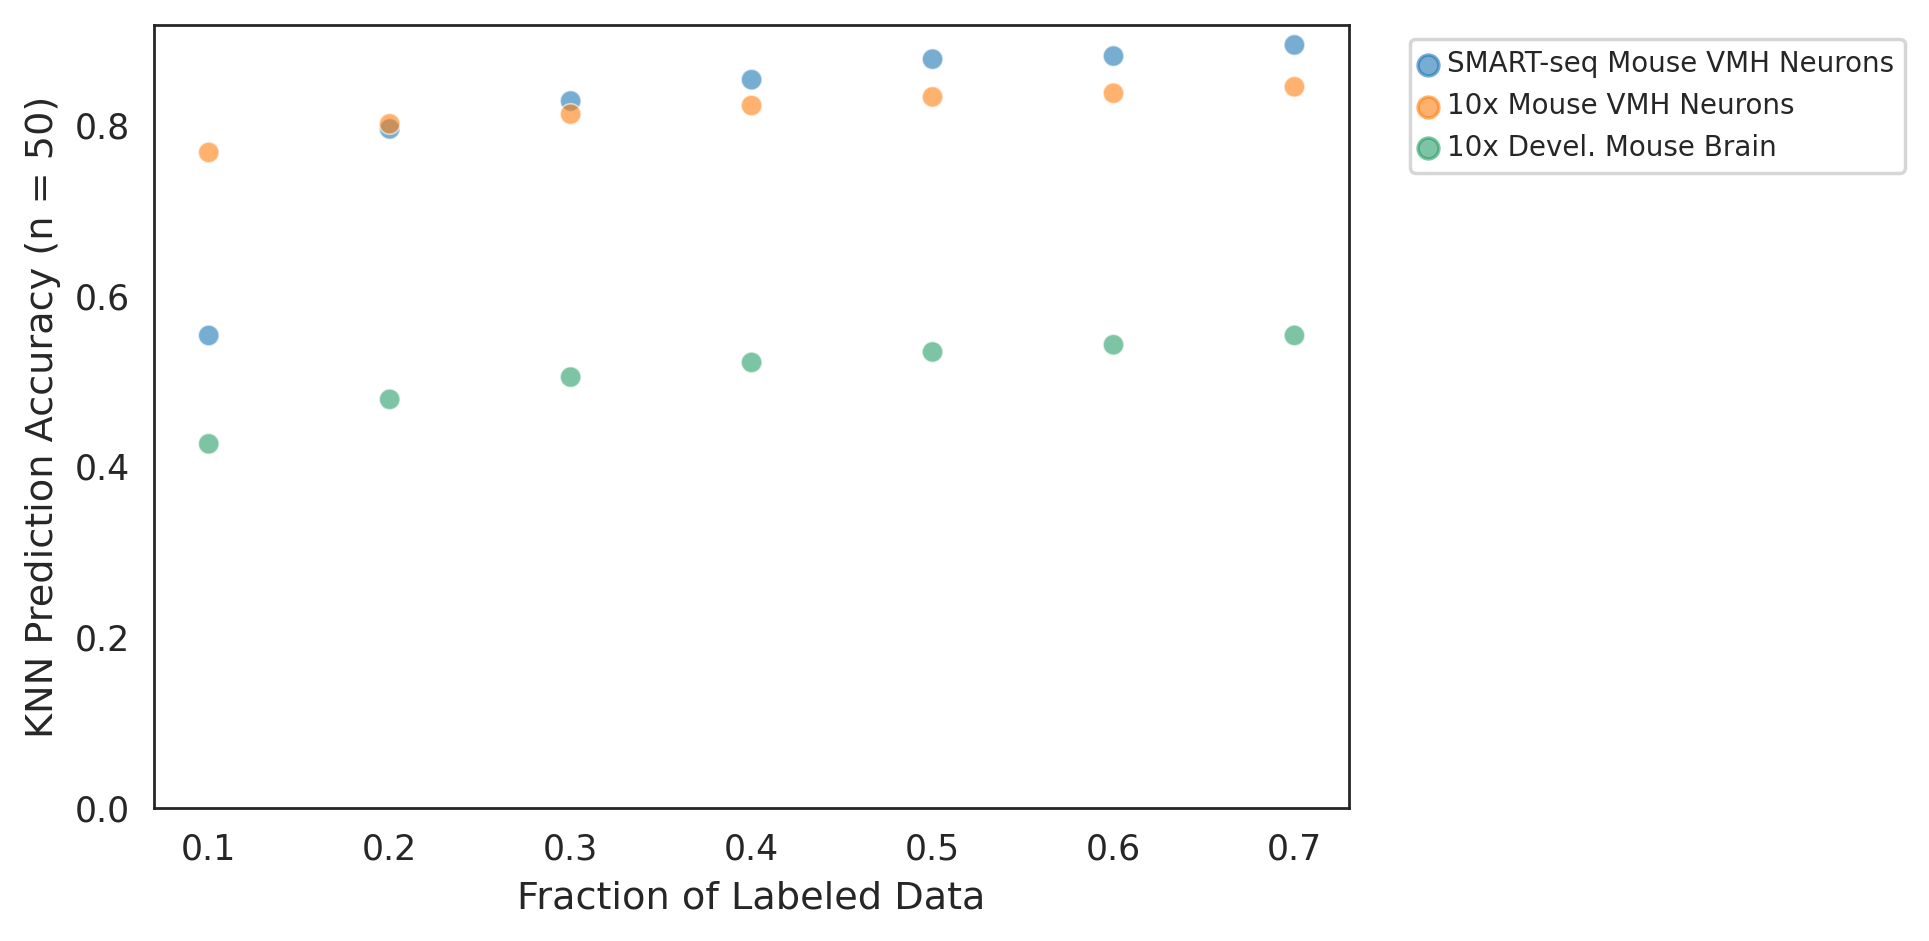

In [ ]:
#Maybe add number of cells below
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Percent', y='Accuracy', data=allPreds, hue='Dataset')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Fraction of Labeled Data",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n = 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

### **Time per Epoch for MCML vs scVI**

In [ ]:
mcmlTimes = pd.read_csv(data_path+'/timeComparisonsMCML.csv')

mcmlTimes.head()

,Unnamed: 0,Time,Dataset,Embed,Cells
0,0,54.109435,pseudotime,LDVAE,1075
1,1,73.946568,pseudotime,SCANVI,1075
2,2,9.272540,pseudotime,Recon MCML 50D,1075
3,3,9.306313,pseudotime,Cell Type MCML 50D,1075
4,4,137.753447,smartseq,LDVAE,3850


In [ ]:
np.unique(mcmlTimes.Dataset)

array(['lamanno', 'pseudotime', 'smartseq', 'tenx'], dtype=object)

In [ ]:
mcmlTimes['Runtime'] = mcmlTimes['Time']

Divide times by number of epochs (so times are comparable across methods)

In [ ]:
#400 epochs - pseudotime, 400 epochs- smartseq, 192 epochs - tenx, 29 epochs - lamanno (scanvi and ldvae)
#100 epochs for all mcml

mcmlTimes['Time'][mcmlTimes['Embed'].isin(['Recon MCML 50D','Cell Type MCML 50D'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['Recon MCML 50D','Cell Type MCML 50D'])]/100
mcmlTimes.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,Time,Dataset,Embed,Cells,Runtime
0,0,54.109435,pseudotime,LDVAE,1075,54.109435
1,1,73.946568,pseudotime,SCANVI,1075,73.946568
2,2,0.092725,pseudotime,Recon MCML 50D,1075,9.272540
3,3,0.093063,pseudotime,Cell Type MCML 50D,1075,9.306313
4,4,137.753447,smartseq,LDVAE,3850,137.753447


In [ ]:
mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['pseudotime','smartseq'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['pseudotime','smartseq'])]/400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['tenx'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['tenx'])]/192

mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['lamanno'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['lamanno'])]/29
mcmlTimes.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Time,Dataset,Embed,Cells,Runtime
0,0,0.135274,pseudotime,LDVAE,1075,54.109435
1,1,0.184866,pseudotime,SCANVI,1075,73.946568
2,2,0.092725,pseudotime,Recon MCML 50D,1075,9.272540
3,3,0.093063,pseudotime,Cell Type MCML 50D,1075,9.306313
4,4,0.344384,smartseq,LDVAE,3850,137.753447


In [ ]:
mcmlTimes['Dataset'] = [i.replace('smartseq','SMART-seq Mouse VMH Neurons\n(3,850 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('tenx','10x Mouse VMH Neurons\n(41,580 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('pseudotime','$\it{C. elegans}$ Devel. Neurons\n(1,075 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('lamanno','10x Devel. Mouse Brain\n(292,495 cells)') for i in mcmlTimes['Dataset']] 


In [ ]:
axisFontSize = 11-2
tickFontSize = 10-2
figsize =(10,4)
dodge=0.4
fname = None
ymin = 0

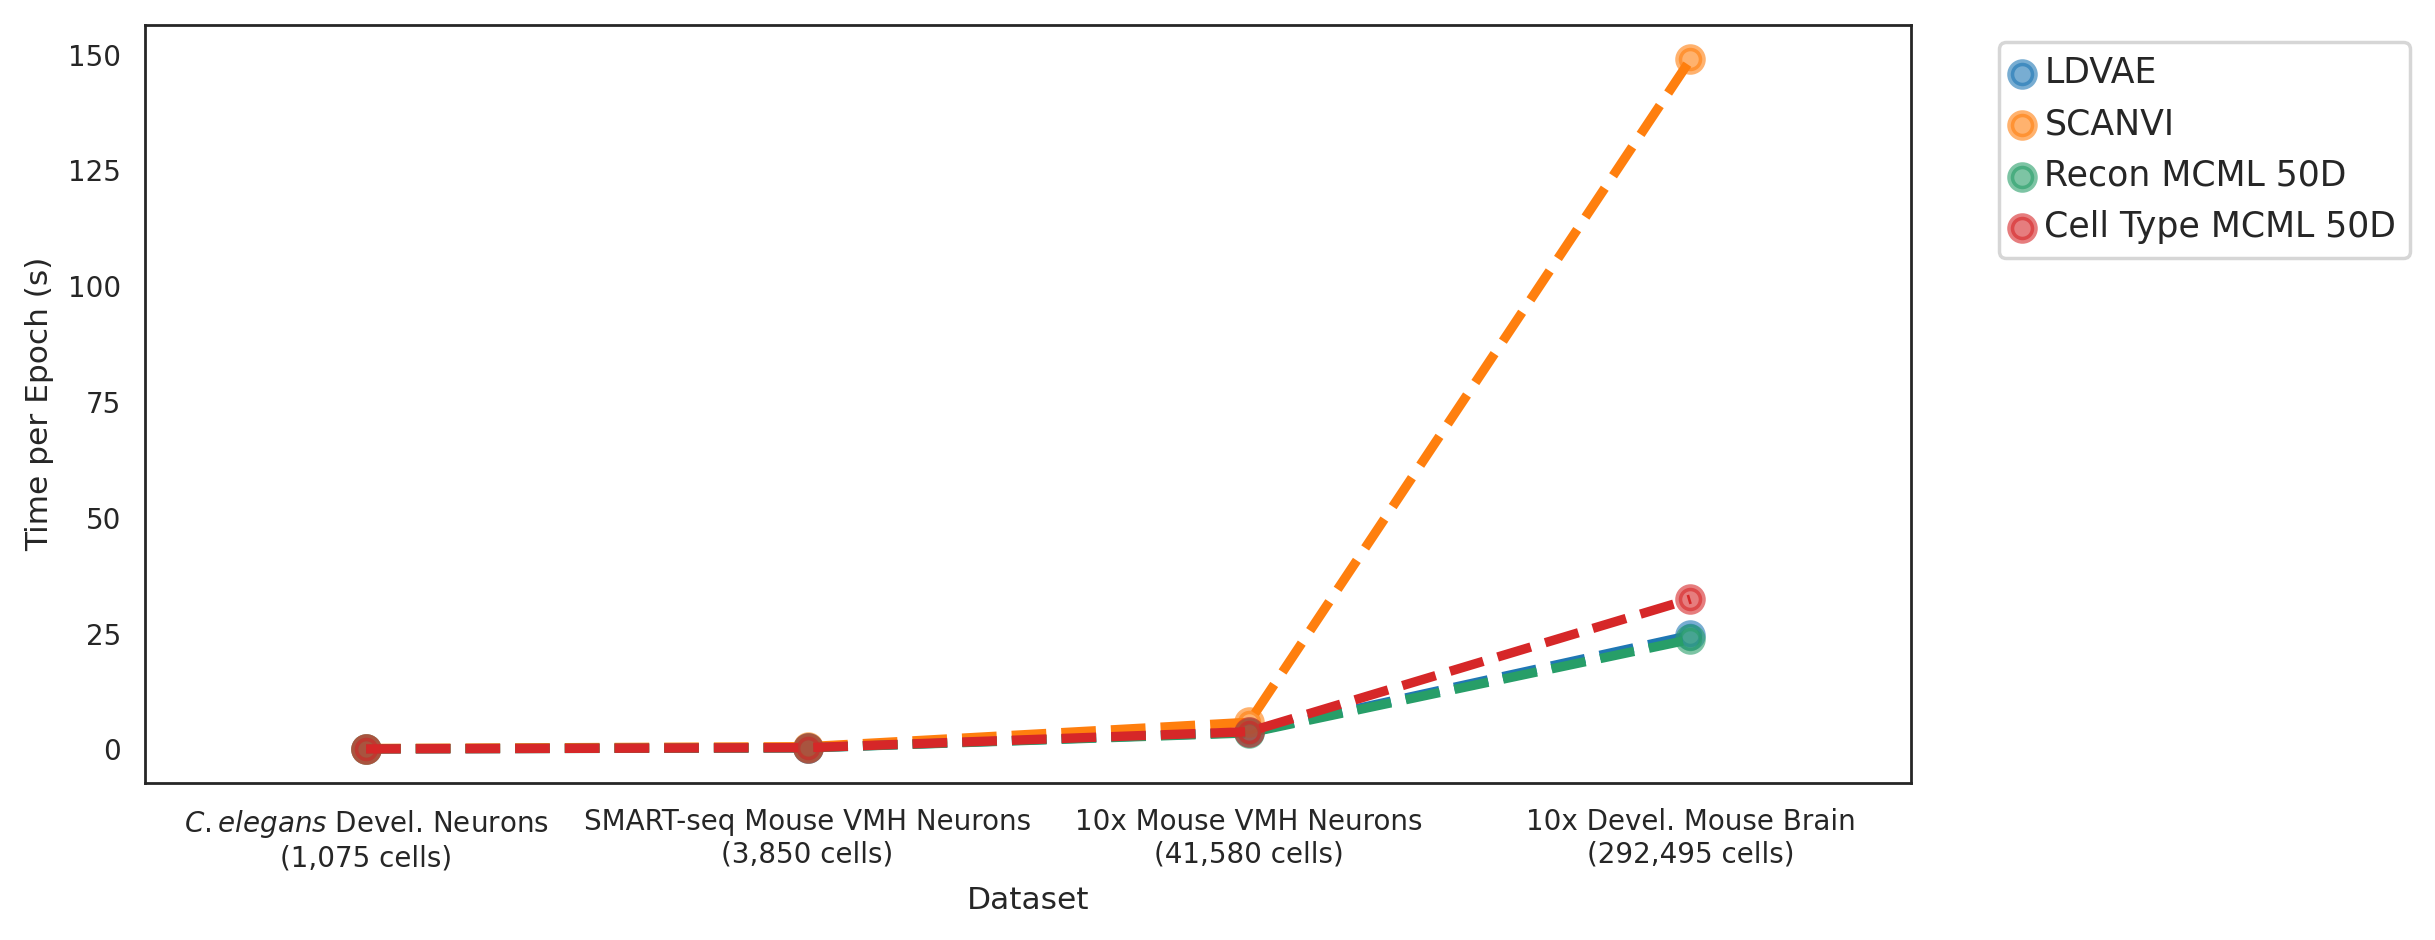

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Time', data=mcmlTimes, hue='Embed',linestyles="--")
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})


plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Time per Epoch (s)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


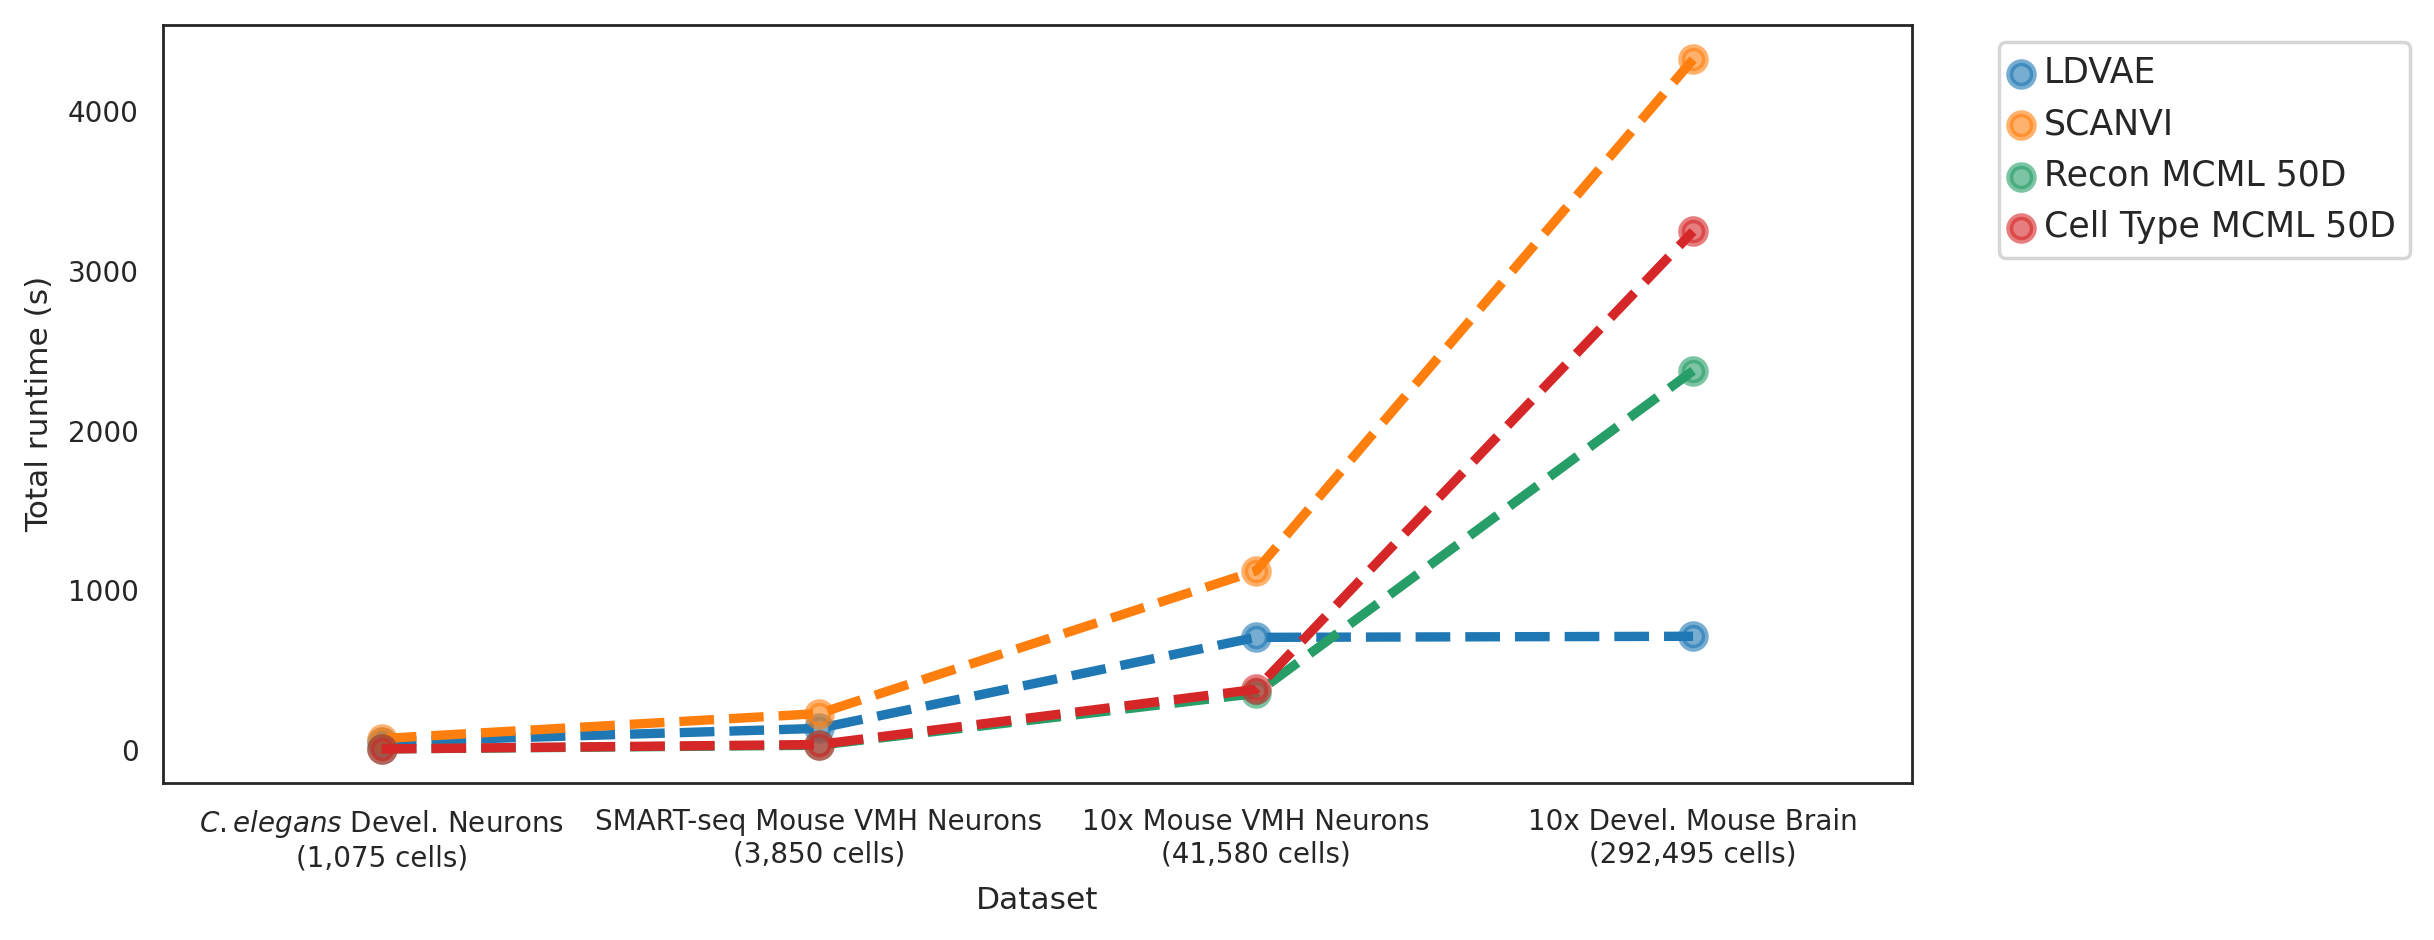

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Runtime', data=mcmlTimes, hue='Embed',linestyles="--")
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})


plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Total runtime (s)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


### **MCML with 100% NCA loss vs sklearn NCA**

In [ ]:
ncaLosses = pd.read_csv(data_path+'/sklearnNCAComps.csv')

ncaLosses.head()

,Unnamed: 0,Loss,Method,Time,Dataset
0,0,0.955284,MCML 50D,562.707319,10x VMH
1,1,0.453261,NCA 50D,3623.649164,10x VMH
2,2,0.956880,MCML 50D,556.053990,10x VMH
3,3,0.455265,NCA 50D,3615.831476,10x VMH
4,4,0.958116,MCML 50D,543.680363,10x VMH


In [ ]:
ncaLosses['Dataset'] = [i.replace('MERFISH','MERFISH MOp\n(6,963 cells)') for i in ncaLosses['Dataset']] 
ncaLosses['Dataset'] = [i.replace('10x VMH','10x Mouse VMH Neurons\n(41,580 cells)') for i in ncaLosses['Dataset']] 


In [ ]:
axisFontSize = 11-2
tickFontSize = 10-2
figsize =(5,3)
dodge=0.4
fname = None
ymin = 0

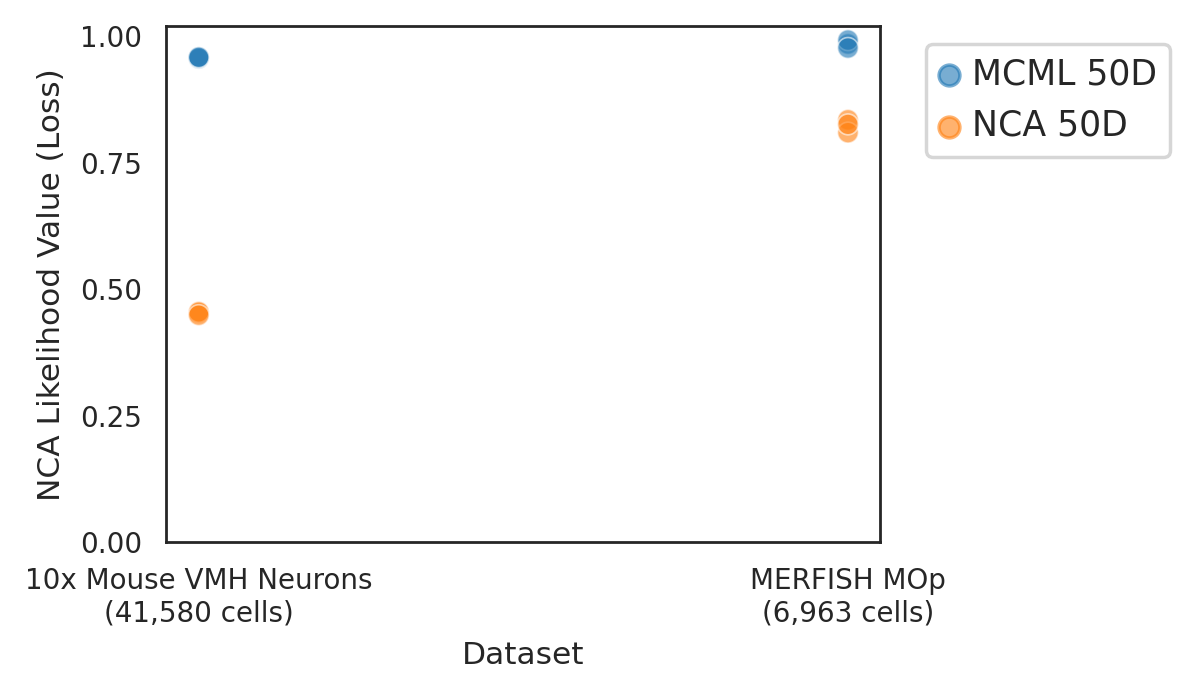

In [ ]:
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Dataset', y='Loss', data=ncaLosses, hue='Method')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.ylim(ymin=ymin)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("NCA Likelihood Value (Loss)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


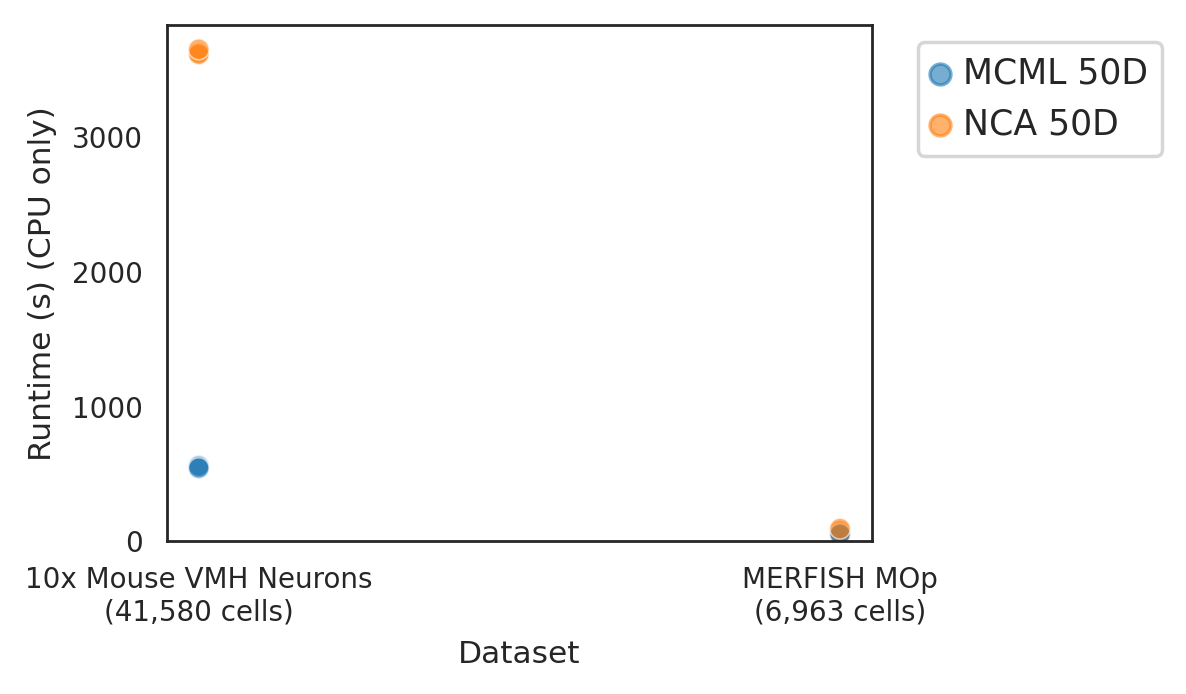

In [ ]:
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Dataset', y='Time', data=ncaLosses, hue='Method')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.ylim(ymin=ymin)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Runtime (s) (CPU only)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()
